In [6]:
import scipy
import os
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
data_df = pd.read_json('milestone_1.json')

In [ ]:
data_2 = data_df.dropna(subset=['final_price_list'])
data_3 = data_2[data_2['final_price_list']!=-1]
data_4 = data_3.copy()
price_list = []
for i in range(len(data_4)):
    plist = data_4.iloc[i]['final_price_list']
    if plist[0] != u'RMB':
        print plist[0]
        price_list.append(np.nan)
    else:
        pvalue = plist[1].replace(',','')
        price_list.append(pvalue)
data_4['final_price_list'] = price_list
data_5 = data_4.dropna(subset=['final_price_list'])

In [ ]:
def get_fan_number_fast(img_name):
    fan = scipy.misc.imread('./img_resized/reshape'+img_name)
    width = len(fan[0])
    height = len(fan)
    width_unit = width / 10
    height_unit = height / 20
    for row in fan[9*height_unit:height-9*height_unit]:
        for cell in row[3*width_unit:width-3*width_unit]:
            _unique, _unique_counts = np.unique(cell, return_counts = True)
            counts = _unique_counts.max() #max number of occurance of one value
            if counts == 3: #means R == G == B
                cell[0] = 255
                cell[1] = 255
                cell[2] = 255
            else:
                continue
    smooth_fan = ndimage.gaussian_filter(fan, 2)

    threshold = 245 - (np.std(fan) - 30)/2 + 1.2
    #threshold = 230
    #print threshold

    labeled, num_objects = ndimage.label(smooth_fan < threshold)
    return num_objects
    #print "Num of objects is %d" %num_objects

    #plt.imshow(smooth_fan)

In [ ]:
fan = scipy.misc.imread('./img/'+'art5072290267.jpg')
np.std(fan)
get_fan_number_fast('art5072290267.jpg')

In [ ]:
name = data_df.sample()['img_name'].values[0]
print name
fan = scipy.misc.imread('./img/'+name)
plt.figure()
plt.imshow(fan)
plt.show()
print get_fan_number_fast(name)

In [ ]:
data_5

In [ ]:
file_name_list = []
price_list = []

In [ ]:
for i in range(len(data_5)):
    if i%10 == 0 :
        print i,
    name = data_5.iloc[i]['img_name']
    if name in file_name_list:
        continue
    try:
        num = get_fan_number_fast(name)
    except IOError:
        continue
    except TypeError:
        print i,'Error'
        continue
    if num ==1 and data_5.iloc[i]['no_img'] != True:
        price_list.append(data_5.iloc[i]['final_price_list'])
        file_name_list.append(data_5.iloc[i]['img_name'])

In [ ]:
len(file_name_list)

In [ ]:
len(price_list)

In [ ]:
data_set = zip(file_name_list, price_list)

In [ ]:
import pickle

with open('data_set.pickle','w') as f:
    pickle.dump(data_set, f)

In [ ]:
with open('data_set.pickle','r') as f:
    dset = pickle.load(f)

In [ ]:
data_for_cnn=pd.DataFrame(dset)

In [ ]:
data_for_cnn.sample(20)[0]

In [ ]:
%matplotlib notebook
fname = data_for_cnn.sample()[0].values[0]
fan = scipy.misc.imread('./img_resized/reshape'+fname)
plt.figure()
plt.imshow(fan)

In [ ]:
def verify_fan(fan):
    windows_size = 10
    y_1 = pd.rolling_median(fan[:,25],windows_size)[windows_size-1:]
    y_2 = pd.rolling_median(fan[:,100],windows_size)[windows_size-1:]
    y_3 = pd.rolling_median(fan[:,175],windows_size)[windows_size-1:]
    y_1_n = 1*(y_1<250)
    y_2_n = 1*(y_2<250)
    y_3_n = 1*(y_3<250)
    y_1_n[0] = 0
    y_2_n[0] = 0
    y_3_n[0] = 0
    y_1_n[-1] = 0
    y_2_n[-1] = 0
    y_3_n[-1] = 0
    y_d_1 = np.abs(y_1_n[1:] - y_1_n[:-1])
    y_d_2 = np.abs(y_2_n[1:] - y_2_n[:-1])
    y_d_3 = np.abs(y_3_n[1:] - y_3_n[:-1])
    n1 = (np.sum(y_d_1)+1)/2
    n2 = (np.sum(y_d_2)+1)/2
    n3 = (np.sum(y_d_3)+1)/2
    #print 'n', n1, n2, n3
    if n1==1 and n1 == n2 and n2 == n3:
        l1 = np.diff(np.where(y_d_1==1)[0])
        l2 = np.diff(np.where(y_d_2==1)[0])
        l3 = np.diff(np.where(y_d_3==1)[0])
        
        #print l1,l2,l3
        #print 
        if l2 > l1 and l2 > l3:
            return True
    return False

In [ ]:
fname = data_for_cnn.sample()[0].values[0]
fan = scipy.misc.imread('./img_resized/reshape'+fname)
plt.figure()
plt.imshow(fan)
verify_fan(fan)

In [ ]:
is_fan_list = []
for i in range(len(data_for_cnn)):
    fname = data_for_cnn.iloc[i][0]
    fan = scipy.misc.imread('./img_resized/reshape'+fname)
    is_fan_list.append(verify_fan(fan))
    print i,

In [ ]:
sum(1*np.r_[is_fan_list])

In [ ]:
data_for_cnn['is_fan'] = is_fan_list

In [ ]:
data_for_cnn_verified = data_for_cnn[data_for_cnn['is_fan']==True]

In [ ]:
plt.figure()
fname = data_for_cnn_verified.sample()[0].values[0]
fan = scipy.misc.imread('./img_resized/reshape'+fname)
plt.imshow(fan)
plt.show()

In [ ]:
img_data_list = []
for i in range(len(data_for_cnn_verified)):
    fname = data_for_cnn_verified.iloc[i][0]
    fan = scipy.misc.imread('./img_resized/reshape'+fname)
    img_data_list.append(fan)
    print i,

In [ ]:
new_list = []
for i in range(len(img_data_list)):
    new_list.append([img_data_list[i]])

In [ ]:
data_img_x = np.array(new_list)

In [ ]:
data_img_x.shape

In [ ]:
data_img_y = np.array(data_for_cnn_verified[1]).astype(int)

In [ ]:
data_img_y.shape

regulization

In [ ]:
y_avg = np.average(data_img_y)

In [ ]:
y_std = np.std(data_img_y)

In [ ]:
y_range = max(data_img_y) - min(data_img_y)

In [ ]:
data_img_y = (data_img_y - y_avg)/y_std 

In [ ]:
data_img_y_range = max(data_img_y) - min(data_img_y)
print data_img_y_range

In [ ]:
data_img_y = data_img_y/data_img_y_range

In [ ]:
t = data_img_y

In [ ]:
t = np.sort(t)

In [ ]:
bins_list = []
num_class = 20
total_num = len(data_img_y)
sub_size = total_num/num_class
count = 0
for i in t:
    if count == sub_size:
        bins_list.append(i)
        count = 0
    count = count + 1

In [ ]:
bins_list

In [ ]:
data_img_y

In [ ]:
data_class_y = []
for y in data_img_y:
    y_class = len(bins_list)
    for i in range(len(bins_list)):
        if y < bins_list[i]:
            y_class = i
            break
    data_class_y.append(y_class)

In [ ]:
data_class_y = np.array(data_class_y)

In [ ]:
np.min(data_class_y)

In [ ]:
data_class_y = data_class_y.astype('int32')

In [ ]:
data_class_y.dtype

In [ ]:
len(total_data)

In [44]:
total_data = pd.DataFrame(zip(data_img_x, data_class_y))

NameError: name 'data_class_y' is not defined

In [3]:
import pickle
import numpy as np

In [4]:
with open('total_data.pickle','r') as f:
    total_data = pickle.load(f)

In [5]:
data_class_y = total_data[1]

In [6]:
data_img_x = []

In [7]:
for line in total_data[0]:
    data_img_x.append(np.array(line))

In [8]:
data_img_x = np.array(data_img_x)

In [9]:
data_img_x.shape

(26474, 1, 200, 200)

defussion map

In [10]:
x_d = data_img_x.reshape(-1,40000).T

In [11]:
from scipy.spatial.distance import pdist, squareform
from scipy import linalg as la
import numpy as np

In [12]:
def diffusion_maps(data, d, eps=-1, t=1):
    """
    data is organized such that columns are points. so it's 60k x 2k for you
    d is the target dimension
    eps is the kernel bandwidth, estimated automatically if == -1
    t is the diffusion time, 1 is usually fine
    """

    distances = squareform(pdist(data.T))

    if eps == -1:
        # if a kernel bandwidth was not supplied,
        # just use the distance to the tenth-nearest neighbor
        k = 10
        nn = np.sort(distances)
        eps = np.mean(nn[:, k + 1])

    kernel = np.exp(-distances ** 2 / eps ** 2)
    one = np.ones(n_samples)
    p_a = np.dot(kernel, one)
    kernel_p = walk / np.outer(p_a, p_a)
    dd = np.dot(kernel_p, one) ** 0.5
    walk = kernel_p / np.outer(dd, dd)

    vecs, eigs, _ = la.svd(walk, full_matrices=False)
    vecs = vecs / vecs[:, 0][:, None]
    diffusion_coordinates = vecs[:, 1:d + 1].T * (eigs[1:d + 1][:, None] ** t)

    return diffusion_coordinates

PCA

In [13]:
from sklearn import decomposition, datasets
from sklearn.preprocessing import StandardScaler

In [14]:
data_img_x = []

In [15]:
for line in total_data[0]:
    data_img_x.append(np.array(line))

In [16]:
data_img_x = np.array(data_img_x)

In [17]:
x_line = data_img_x.reshape(-1,40000)

In [18]:
import matplotlib.pyplot as plt

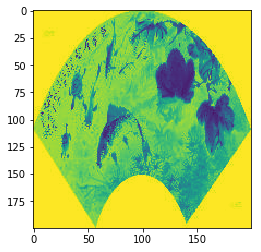

In [19]:
plt.figure()
plt.imshow(x_line[0].reshape(200,200))
plt.show()

In [24]:
sc = StandardScaler()

In [21]:
X_std = sc.fit_transform(x_line)

/Users/dongzhangliang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


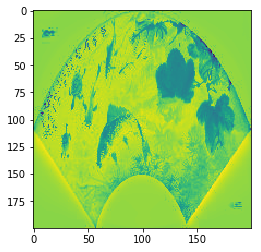

In [22]:
plt.figure()
plt.imshow(X_std[0].reshape(200,200))
plt.show()

In [25]:
import re
import pickle

In [ ]:
with open('X_std.pickle','w') as f:
    pickle.dump(X_std, f)

In [23]:
with open('n_data.pickle','r') as f:
    X_std = pickle.load(f)

NameError: name 'X_std' is not defined

In [131]:
pca = decomposition.PCA(n_components=44*44)
X_std_pca = pca.fit_transform(X_std)

In [222]:
X_std_pca.shape

(26474, 1936)

In [ ]:
np.aver

In [224]:
proj = pca.inverse_transform(X_std_pca[0])

<IPython.core.display.Javascript object>


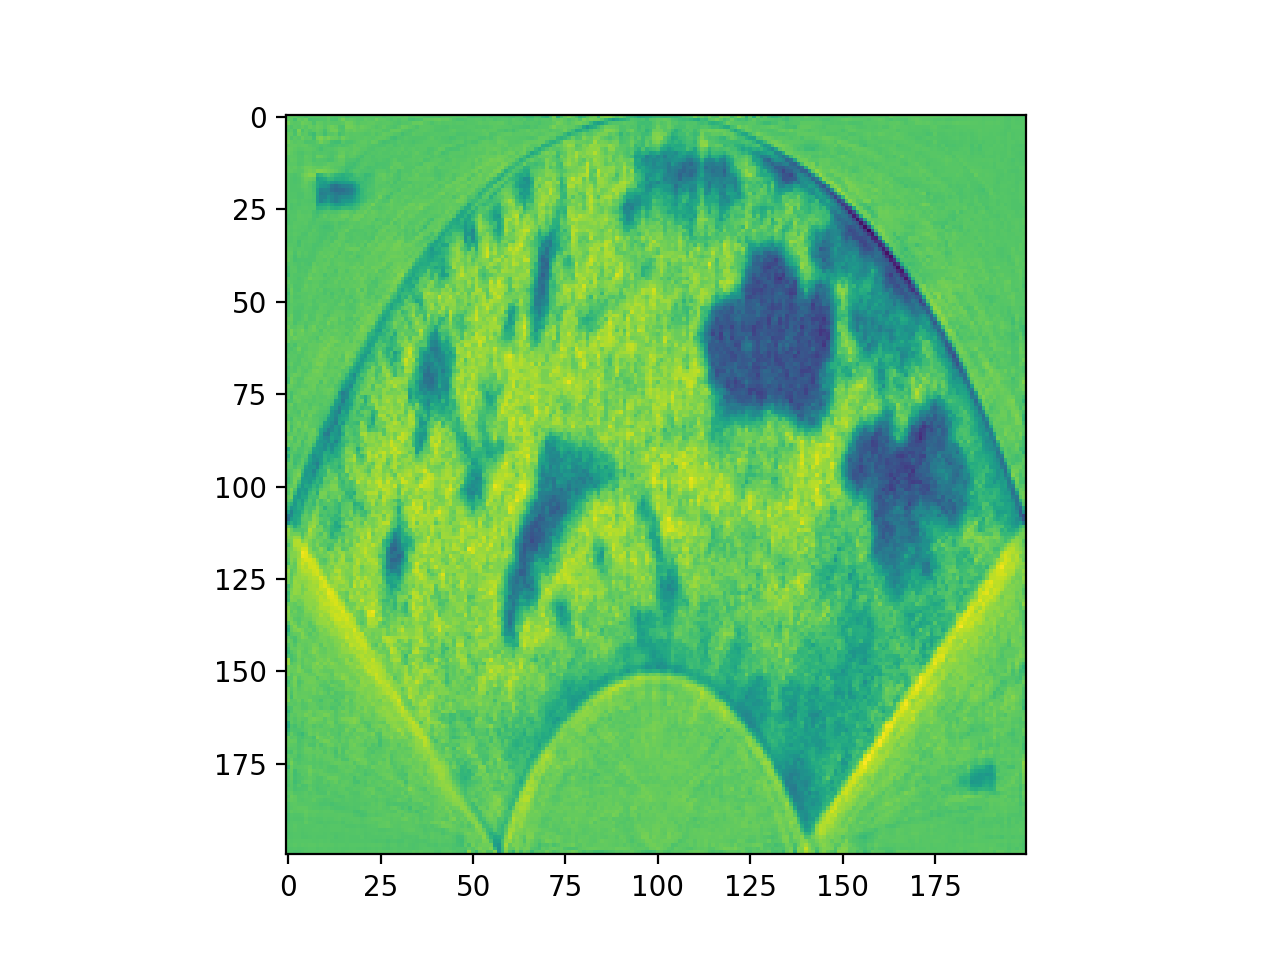

In [225]:
plt.figure()
plt.imshow(proj.reshape(200,200))
plt.show()

with open('X_std_pca_44_44.pickle','w') as f:
    pickle.dump(X_std_pca, f)

In [2]:
with open('X_std_pca_44_44.pickle','r') as f:
    X_std_pca = pickle.load(f)

NameError: name 'pickle' is not defined

20% test set  
80% train set

In [133]:
together_data = pd.DataFrame(zip(X_std_pca, data_class_y))

In [134]:
msk = np.random.rand(len(total_data)) < 0.8
train = together_data[msk]
test = together_data[~msk]

In [151]:
X_train = train[0]
y_train = train[1]
X_test = test[0]
y_test = test[1]

In [152]:
X_train = np.array(X_train.tolist()).reshape(-1,1,44,44)
y_train = np.array(y_train.tolist()).astype('int32')
X_test = np.array(X_test.tolist()).reshape(-1,1,44,44)
y_test = np.array(y_test.tolist()).astype('int32')

<IPython.core.display.Javascript object>


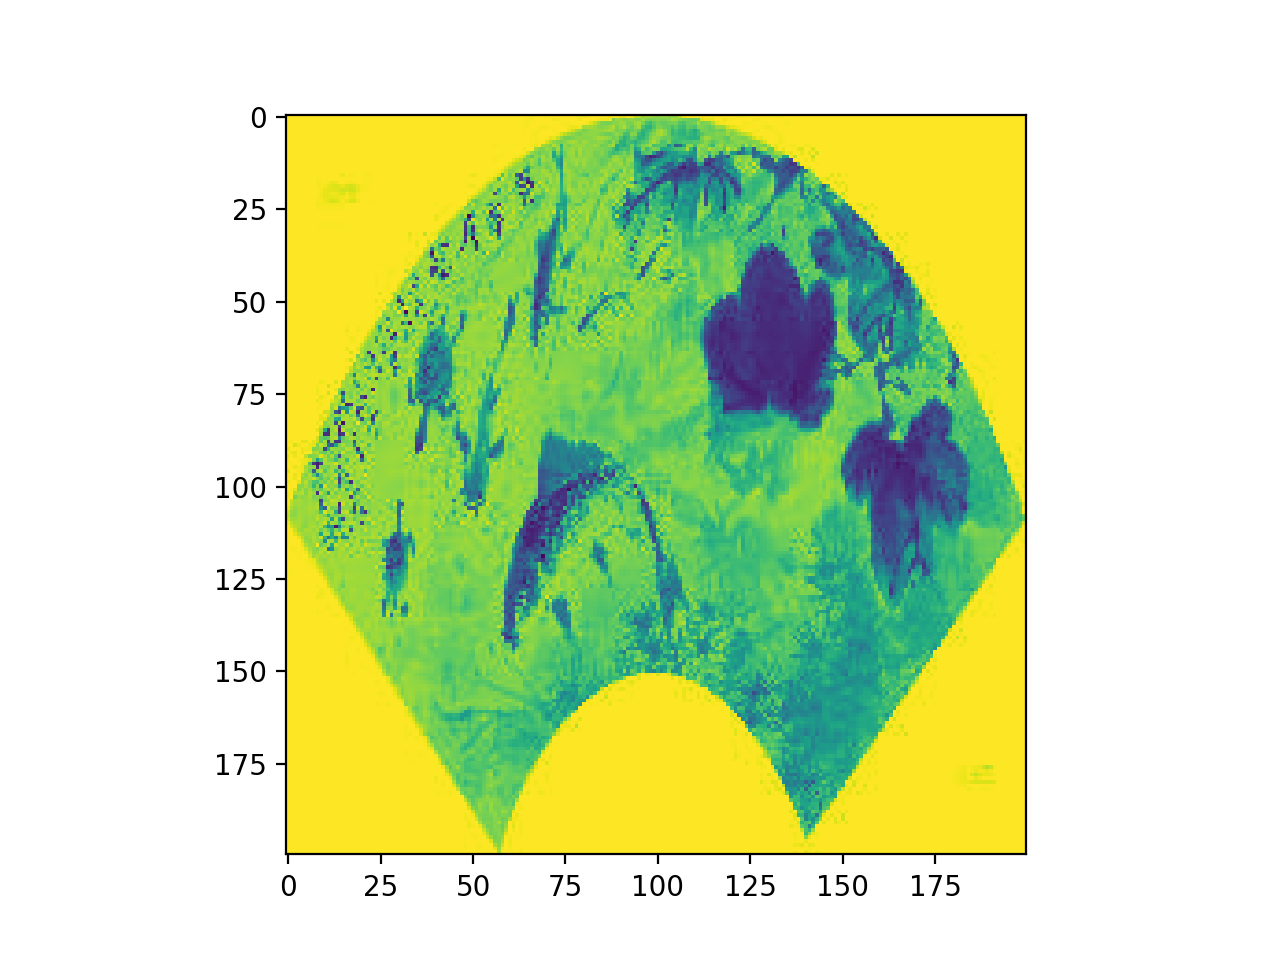

In [184]:
plt.imshow(X_train[80][0])

In [153]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from urllib import urlretrieve
import cPickle as pickle
import os
import gzip
import numpy as np
import theano
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [154]:
net1 = NeuralNet(
    layers=[('input', layers.InputLayer),
            ('conv2d1', layers.Conv2DLayer),
            ('maxpool1', layers.MaxPool2DLayer),
            ('conv2d2', layers.Conv2DLayer),
            ('maxpool2', layers.MaxPool2DLayer),
            ('dropout1', layers.DropoutLayer),
            ('dense', layers.DenseLayer),
            ('dropout2', layers.DropoutLayer),
            ('output', layers.DenseLayer),
            ],
    # input layer
    input_shape=(None, 1, 44,44),
    # layer conv2d1
    conv2d1_num_filters=32*2,
    conv2d1_filter_size=(2, 2),
    conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1_W=lasagne.init.GlorotUniform(),  
    # layer maxpool1
    maxpool1_pool_size=(2, 2),    
    # layer conv2d2
    conv2d2_num_filters=32*2,
    conv2d2_filter_size=(2, 2),
    conv2d2_nonlinearity=lasagne.nonlinearities.rectify,
    # layer maxpool2
    maxpool2_pool_size=(2, 2),
    # dropout1
    dropout1_p=0.5,    
    # dense
    dense_num_units=256,
    dense_nonlinearity=lasagne.nonlinearities.rectify,    
    # dropout2
    dropout2_p=0.5,    
    # output
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=21,
    # optimization method params
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,
    max_epochs=10,
    verbose=3,
    )

In [155]:
# Train the network
nn = net1.fit(X_train, y_train)

# Neural Network with 556405 learnable parameters

## Layer information

name      size        total    cap.Y    cap.X    cov.Y    cov.X    filter Y    filter X    field Y    field X
--------  --------  -------  -------  -------  -------  -------  ----------  ----------  ---------  ---------
input     1x44x44      1936   100.00   100.00   100.00   100.00          44          44         44         44
conv2d1   32x40x40    51200   100.00   100.00    11.36    11.36           5           5          5          5
maxpool1  32x20x20    12800   100.00   100.00    11.36    11.36           5           5          5          5
conv2d2   32x16x16     8192    76.92    76.92    29.55    29.55          10          10         13         13
maxpool2  32x8x8       2048    76.92    76.92    29.55    29.55          10          10         13         13
dropout1  32x8x8       2048   100.00   100.00   100.00   100.00          44          44         44         44
dense     256           256   100.00   100.00  

In [156]:
preds = net1.predict(X_test)

<IPython.core.display.Javascript object>


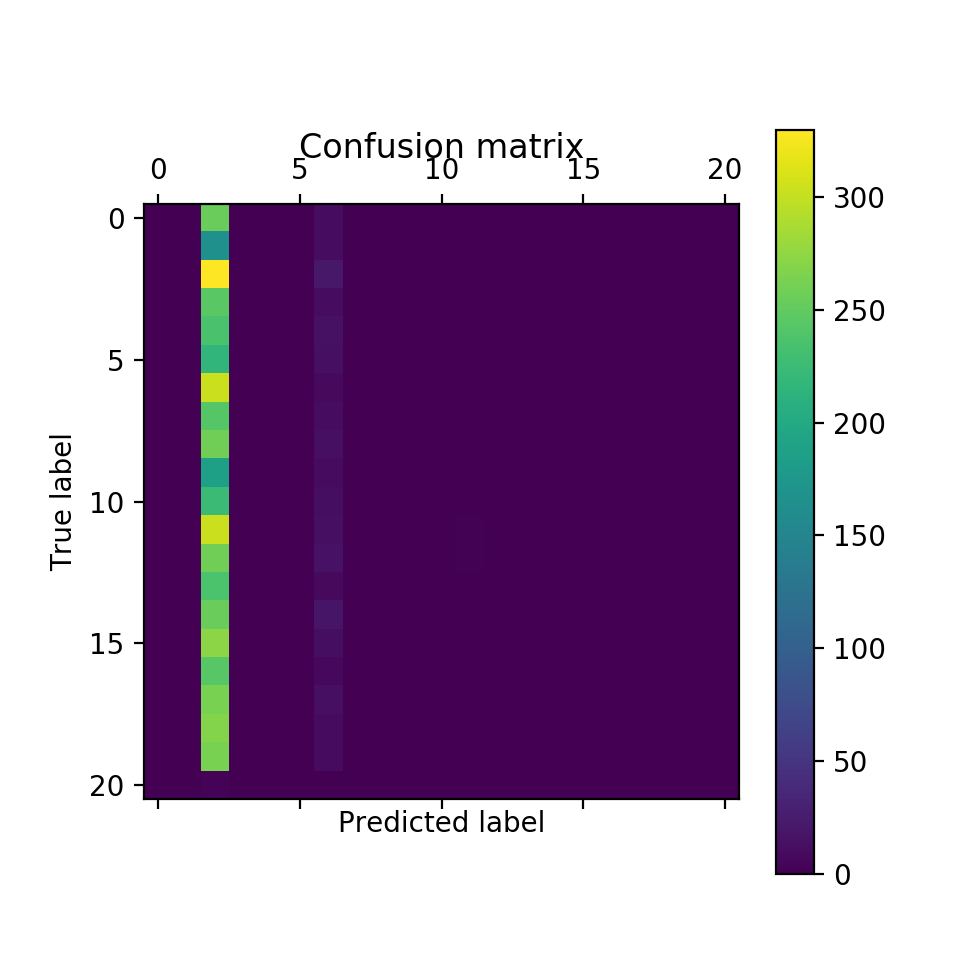

In [157]:
cm = confusion_matrix(y_test, preds)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data